# Exploratory data analysis process

In this notebook, I will analyze the data structure my Top Spotify Tracks from 2016 to 2022.The dataset contains 100 of my top songs each year .

In [35]:
#Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud
from collections import Counter

# Import the library
import plotly.express as px

In [ ]:
# Define colors for plots
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
]

## Load data

In [181]:
songs = pd.read_csv('../data/my_top_songs.csv')
songs.head()

,Unnamed: 0,artist_name,artist_pop,artist_genres,track_name,track_id,track_uri,popularity,danceability,energy,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,year
0,0,Alan Walker,82,['electro house'],Faded,1brwdYwjltrJo7WHpIvbYt,1brwdYwjltrJo7WHpIvbYt,0,0.589,0.651,...,0.166,90.011,audio_features,1brwdYwjltrJo7WHpIvbYt,spotify:track:1brwdYwjltrJo7WHpIvbYt,https://api.spotify.com/v1/tracks/1brwdYwjltrJ...,https://api.spotify.com/v1/audio-analysis/1brw...,212627,4,2016
1,1,Twenty One Pilots,81,"['modern rock', 'rock']",Ride,2Z8WuEywRWYTKe1NybPQEW,2Z8WuEywRWYTKe1NybPQEW,83,0.645,0.713,...,0.566,74.989,audio_features,2Z8WuEywRWYTKe1NybPQEW,spotify:track:2Z8WuEywRWYTKe1NybPQEW,https://api.spotify.com/v1/tracks/2Z8WuEywRWYT...,https://api.spotify.com/v1/audio-analysis/2Z8W...,214507,4,2016
2,2,New Beat Fund,41,[],No Type,4fxtYgcIOqjCq9Ix1pvrzn,4fxtYgcIOqjCq9Ix1pvrzn,47,0.619,0.622,...,0.210,136.978,audio_features,4fxtYgcIOqjCq9Ix1pvrzn,spotify:track:4fxtYgcIOqjCq9Ix1pvrzn,https://api.spotify.com/v1/tracks/4fxtYgcIOqjC...,https://api.spotify.com/v1/audio-analysis/4fxt...,213797,4,2016
3,3,The Strumbellas,58,"['canadian indie', 'folk-pop', 'pop rock', 'st...",Spirits,1mqbTByfUxLPeqN1YEw08a,1mqbTByfUxLPeqN1YEw08a,0,0.553,0.724,...,0.775,80.517,audio_features,1mqbTByfUxLPeqN1YEw08a,spotify:track:1mqbTByfUxLPeqN1YEw08a,https://api.spotify.com/v1/tracks/1mqbTByfUxLP...,https://api.spotify.com/v1/audio-analysis/1mqb...,203653,4,2016
4,4,Kygo,81,"['edm', 'pop', 'pop dance', 'tropical house']",Raging (feat. Kodaline),6DsFZITJMPnh8z5XewfVmL,6DsFZITJMPnh8z5XewfVmL,61,0.550,0.689,...,0.408,99.904,audio_features,6DsFZITJMPnh8z5XewfVmL,spotify:track:6DsFZITJMPnh8z5XewfVmL,https://api.spotify.com/v1/tracks/6DsFZITJMPnh...,https://api.spotify.com/v1/audio-analysis/6DsF...,224487,4,2016


## Data Preparation
First we need to prepare our dataframe. We're going to drop columns `track_id`, `track_uri`, `type`, `id`, `uri`,`track_href` and `analysis_url` as we don't need them for this application. Then we convert the song duration from millieseconds to seconds

In [182]:
#Drop columns
columns_to_drop=['track_id', 'track_uri', 'type', 'id', 'uri','track_href','analysis_url']
songs=songs.drop(columns_to_drop,axis=1)
# Convert duration from ms to sec
songs['duration_ms']=songs['duration_ms']*10**-3
songs=songs.dropna()
# Remove symbols from text
songs['artist_genres'] =songs['artist_genres'].apply( lambda x: re.sub(r"'", "", x, flags=re.MULTILINE))
songs['artist_name'] =songs['artist_name'].apply(str)
songs['artist_name'] =songs['artist_name'].apply( lambda x: re.sub(r'[^\w\s]', "", x, flags=re.MULTILINE))

songs = songs.rename(columns={'Unnamed: 0': 'rank', 'oldName2': 'newName2'})

## Data Visualisation
### Favorite gernes
First we're going to visualise what are the most common genres the artist I listened more over the years are associated with, by creating a wordcloud based on music genre

Text(0.5, 1.0, 'Favorite artist gernes')

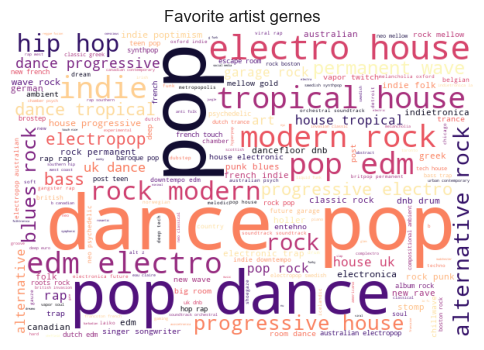

In [185]:
top_gernes = ' '.join([word for word in songs['artist_genres']])
wordcloud_gernes = WordCloud(width=600,
                             height=400,
                             random_state=2,
                             max_font_size=100,
                             colormap='magma',
                             background_color="white").generate(top_gernes)


# Create a figure object and set its size and title
fig = plt.figure(figsize=(6, 6))
# showing image
plt.imshow(wordcloud_gernes)
plt.axis('off')
plt.title("Favorite artist gernes")

### Favorite gernes each year

In [189]:
df=songs.groupby("year")["artist_genres"].apply(lambda x: Counter(" ".join(x).split(',')).most_common(5)).to_frame()
df.reset_index(inplace=True)
df=df.explode('artist_genres')
df[['genres','count']] = pd.DataFrame(df['artist_genres'].tolist(), index= df.index)
df=df.drop(['artist_genres'],axis=1)

In [186]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment
def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        ) 

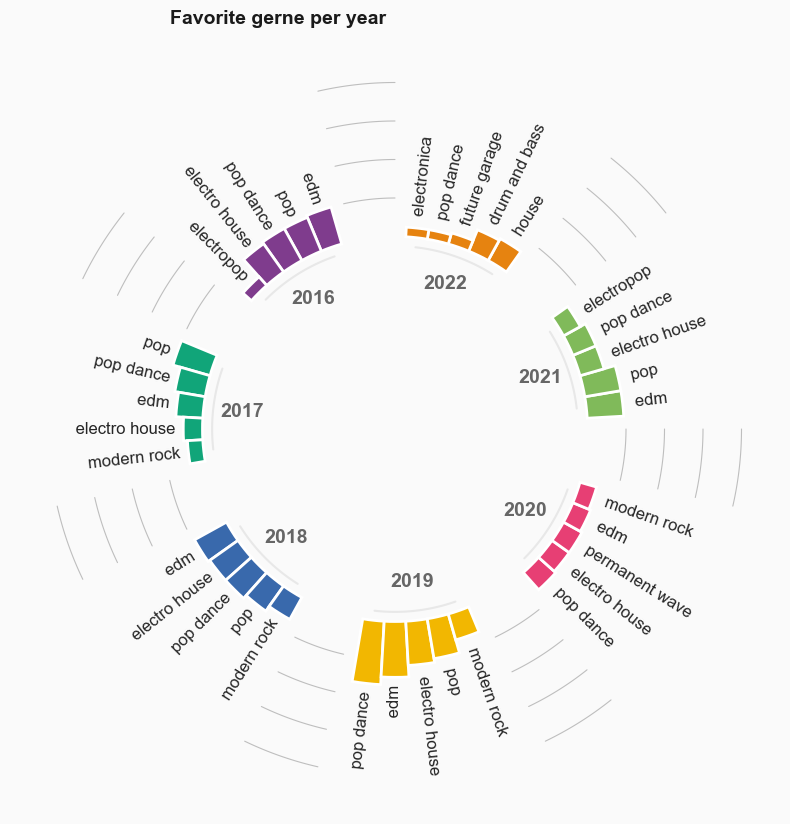

In [247]:
# All this part is like the code above
VALUES = df["count"].values
LABELS = df["genres"].values
GROUP = df["year"].values

PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [5,5,5,5,5,5,5]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

fig.text(
    0.4,
    0.9,
    "Favorite gerne per year",
    color=GREY10,
    fontsize=14,
    weight="bold"
)

#COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

COLORS = [COLOR_SCALE[i] for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]


ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size in zip(np.unique(GROUP), GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color=GREY91)
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -20, group, color=GREY40, fontsize=14, 
        fontweight="bold", ha="center", va="center"
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [80] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD

### Favorite artists over the years

Text(0.5, 1.0, 'Favorite artist gernes')

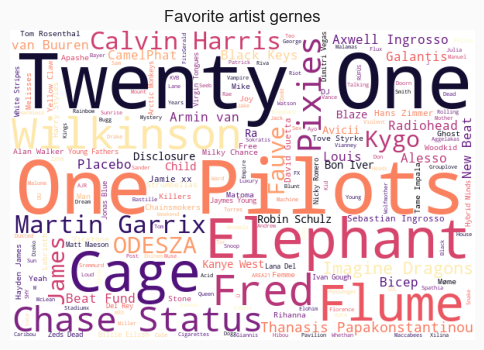

In [33]:
artists = ' '.join([word for word in songs['artist_name']])
wordcloud_gernes = WordCloud(width=600,
                             height=400,
                             random_state=2,
                             max_font_size=100,
                             colormap='magma',
                             background_color="white").generate(artists)


# Create a figure object and set its size and title
fig = plt.figure(figsize=(6, 6))
# showing image
plt.imshow(wordcloud_gernes)
plt.axis('off')
plt.title("Favorite artist gernes")

In [38]:
#Find most loved artists over the years
artists =songs.loc[:,'artist_name']
# Use the Counter class to count the frequency of each word
word_counts = Counter(artists)
# Use the most_common() method to get the most common words
most_common_words = word_counts.most_common(20)
# Create dataframe
common_df = pd.DataFrame(most_common_words, columns=['Artist', 'Count'])

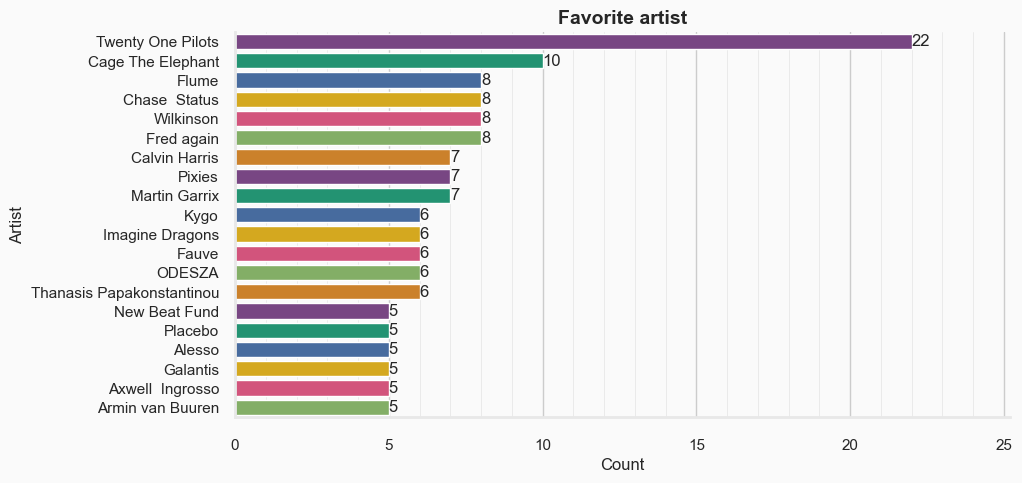

In [48]:
# plot 20 most common words after stemming
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (10, 5))
# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)b

# Vertical lines every year
VLINES = np.arange(0, 25)
# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

art=sns.barplot(data=common_df, y='Artist', x='Count', palette=COLOR_SCALE,orient="h")
art.set_title("Favorite artist",fontdict= { 'fontsize': 14, 'fontweight':'bold'})
art.bar_label(ax.containers[0])
plt.show()

In [58]:
index=songs.duplicated(subset=['artist_name','track_name'],keep=False)
dup=songs[index].sort_values(by=['artist_name'])
dup

# Use the Counter class to count the frequency of each word
dup_counts = Counter(dup.loc[:,'artist_name']).most_common(20)
# Create dataframe
dup_df = pd.DataFrame(dup_counts, columns=['Artist', 'Count'])
dup_df

,Artist,Count
0,Twenty One Pilots,14
1,Cage The Elephant,8
2,Imagine Dragons,5
3,New Beat Fund,5
4,Pixies,5
5,Axwell Ingrosso,4
6,Disclosure,4
7,Flume,4
8,Galantis,4
9,Sebastian Ingrosso,4


Now that we have the data, let’s take a look at the features for each song. For this subpart specifically, we will be looking at the mean values of the features for the top 100 most popular songs, as well as all of the dataset. To visualize this we can use a radar chart as below. The code below is:

Obtaining all of the labels of the data, in our case the audio features, and taking their means. There are two variables: “features”, with the average values of the audio features for the top 100 songs and “features_all”, with the means for all of the dataset.
Plotting the “features” and “features_all” on the same radar plot with different colors.

In [14]:
# ------- Mean of feautures
features= ['danceability','liveness','energy','valence','speechiness','acousticness','year']
song_feat=songs.loc[:,features]

summary_stats = song_feat.groupby(["year"]).mean().reset_index()
summary_stats

,year,danceability,liveness,energy,valence,speechiness,acousticness
0,2016,0.562790,0.185757,0.638416,0.373442,0.071155,0.262579
1,2017,0.567169,0.169356,0.644439,0.418400,0.076620,0.238498
2,2018,0.566530,0.217587,0.691392,0.477413,0.072232,0.178218
3,2019,0.554260,0.186681,0.703310,0.396293,0.065344,0.184734
4,2020,0.527760,0.192101,0.583556,0.327214,0.059749,0.302582
5,2021,0.586440,0.200292,0.735560,0.396587,0.077191,0.178366
6,2022,0.575220,0.168678,0.736020,0.312120,0.070012,0.146594


Text(0.4, 0.9, 'Audio Features')

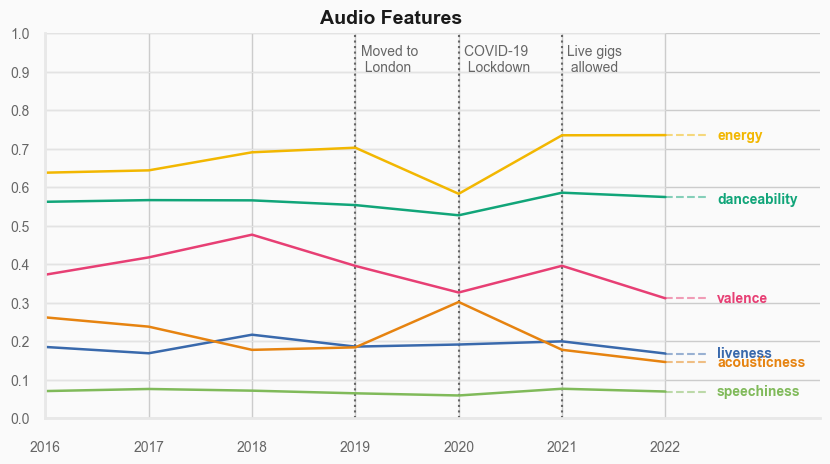

In [42]:
# Vertical lines every year
VLINES = np.arange(2016, 2023)

# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (10, 5))
# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 1.1 ,0.1), xmin=2016, xmax=2022, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2016, xmax=2022, color=GREY60, lw=0.8)

# Vertical like at x = 2019
ax.axvline(2019, color=GREY40, ls="dotted")
# Annotations indicating the meaning of the vertical line
ax.text(2019.05, 0.9, "Moved to \n London",
        fontsize=10, fontweight=500, color=GREY40, ha="left")

# Vertical like at x = 2020
ax.axvline(2020, color=GREY40, ls="dotted")
# Annotations indicating the meaning of the vertical line
ax.text(2020.05, 0.9, "COVID-19 \n Lockdown",
        fontsize=10, fontweight=500, color=GREY40, ha="left")

# Vertical like at x = 2021
ax.axvline(2021, color=GREY40, ls="dotted")
# Annotations indicating the meaning of the vertical line
ax.text(2021.05, 0.9, "Live gigs \n allowed",
        fontsize=10, fontweight=500, color=GREY40, ha="left")

# Annotations indicating the meaning of the vertical line
#ax.text(2019.15, -0.35, "2019",fontsize=14, fontweight=500, color=GREY40, ha="left")

# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(2016, 2023.5)
ax.set_ylim(0, 1)

# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.around(np.arange(0, 1.1 , 0.1),2)])
ax.set_yticklabels(
    [y for y in np.around(np.arange(0, 1.1 , 0.1),2)],
    fontsize=10,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in np.arange(2016, 2023)])
ax.set_xticklabels(
    [x for x in np.arange(2016, 2023)],
    fontsize=10,
    weight=500,
    color=GREY40
)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

#fig.title('Song features')


# Positions
LABEL_Y = [
    0,
    0.57,  # ARG
    0.168,  # BRA
    0.736,    # CHE
    0.312,   # DNK
    0.07,  # EUZ
    0.146,   # GBR
]

#0.575220,0.168678,0.736020,0.312120,0.070012,0.146594


x_start = 2022
x_end = 2022.5
PAD = 0.1

for idx, feature in enumerate(summary_stats):
    if idx!=0:
        color = COLOR_SCALE[idx]
        ax.plot("year", feature, color=color, lw=1.8, data=summary_stats)
        # Country name
        text = feature

        # Vertical start of line
        y_start = summary_stats[feature].values[-1]
        # Vertical end of line
        y_end = LABEL_Y[idx]

        # Add line based on three points
        ax.plot(
            [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD],
            [y_start, y_start, y_start],
            color=color,
            alpha=0.5,
            ls="dashed"
        )

        # Add country text
        ax.text(
            x_end,
            y_end,
            text,
            color=color,
            fontsize=10,
            weight="bold",
            va="center"
        )

fig.text(
    0.4,
    0.9,
    "Audio Features",
    color=GREY10,
    fontsize=14,
    weight="bold"
)



We can observe from the plot above that from 2016 to 2019 the energy of the songs I was listening too started to increase along with valence and liveness. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
At the start of 2019 I experience my first heartbreak and in October 2019 I moved to london which explains why the  valence of the songs started to decrease.In 2020, covid-19 happened and most of the year was spend in a lockdown.As aresult the valence continued to decrease and the energy of the songs also decreased significantly. The dancebility up to 2020 is pretty steady. At the end of 2021 restrictions were lifted in London and live events were allowed again. I started going to a lot of concerts and seeing a lot of new djs .This is the reson the energy, valence and dancebility increased a lot afte 2020. 
In 2022 I was struggling a lot mentally which explains why the valence decreased and reached the same level as 2020

Text(0.5, 0.98, 'Songs Tempo')

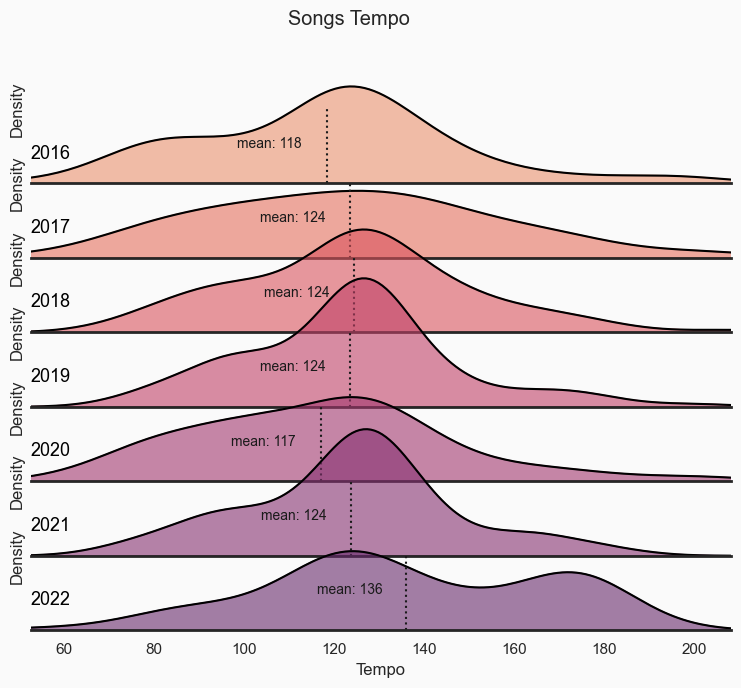

In [201]:
# Ridge plot of Tempo
# Theme
# Initialize layout ----------------------------------------------
sns.set_theme(style="white", rc={"axes.facecolor":(0, 0, 0, 0) , 'axes.linewidth':2, 'figure.facecolor':'"#fafafa"'})
palette = sns.color_palette("flare", 7)

# create a grid with a row for each 'Language'
g = sns.FacetGrid(songs, palette=palette, row="year", hue="year", height=1, aspect=8)

# map df - Kernel Density Plot of IMDB Score for each Language
g.map_dataframe(sns.kdeplot, x="tempo", fill=True, alpha=0.6)
g.map_dataframe(sns.kdeplot, x="tempo", color='black')

# Add vertical lines for mean tempo on each plot
def vertical_mean(x, **kwargs):
    plt.axvline(x.mean(), ymin=0, ymax=0.5, color=GREY10, ls="dotted")
    tx = "mean: {:.0f}".format(x.mean())
    txkw = dict(size=10, color = GREY10)
    plt.text(x.mean()-20, 0.006, tx, **txkw)
    
g.map(vertical_mean, 'tempo',clip_on=False)

# function to draw labels
def label(x, color, label):
    ax = plt.gca() #get current axis
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
# iterate grid to plot labels
g.map(label, "year")

# adjust subplots to create overlap
g.fig.subplots_adjust(hspace=-.5)

# remove subplot titles
g.set_titles("")

g.set(xlim=(songs['tempo'].min(), songs['tempo'].max()), ylim=(0,0.025))
# remove yticks and set xlabel
g.set(yticks=[], xlabel="Tempo")
# remove left spine
g.despine(left=True)
# set title
plt.suptitle('Songs Tempo', y=0.98)

Tempo represents the overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. As I mentioned above, I typically listen to all kinds of electronic music and rock music. Below is a list of some common electronic music genres and the tempos that are typically associated with each:

* Hip Hop	85–95 BPM
* Glitch Hop	105–115 BPM
* Techno	120–125 BPM
* House	115–130 BPM
* Electro	128 BPM
* Dubstep	140 BPM (with a half time, 70 BPM feel)
* Drum and Bass	174 BPM

We observe from the plot above that after. We can observe from the plot above that the mean tempo of the tracks I listen to didn't change from 2016 to 2021. In 2020 we can observe that the distribution is left skewed while in 2021 is more symmetric. In 2022 we observe that the mean tempo increases significantly and there is a new peak arounf 160 bpms. 
As I mentioned above, at the end of 2021 restrictions were lifted in London and live events were allowed again. By this time I started to get into techo, techno house and drum and bass. This results to the second peak at around 175 bpms. 

### Artist and Track Popularity 
The popularity of the track has a value between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. 
The artist's popularity is calculated from the popularity of all the artist's tracks.

In [221]:
# Create popularity dataframe
popularity=songs.loc[:,['year','artist_pop','popularity']]
#Rename columns
popularity = popularity.rename(columns={'artist_pop': 'Artist', 'popularity': 'Track'})
# "Melt" the dataset to "long-form" or "tidy" representation
popularity=pd.melt(popularity, "year", var_name="popularity")

,year,popularity,value
0,2016,Artist,82
1,2016,Artist,81
2,2016,Artist,41
3,2016,Artist,58
4,2016,Artist,81
...,...,...,...
1393,2022,Track,56
1394,2022,Track,53
1395,2022,Track,47
1396,2022,Track,90


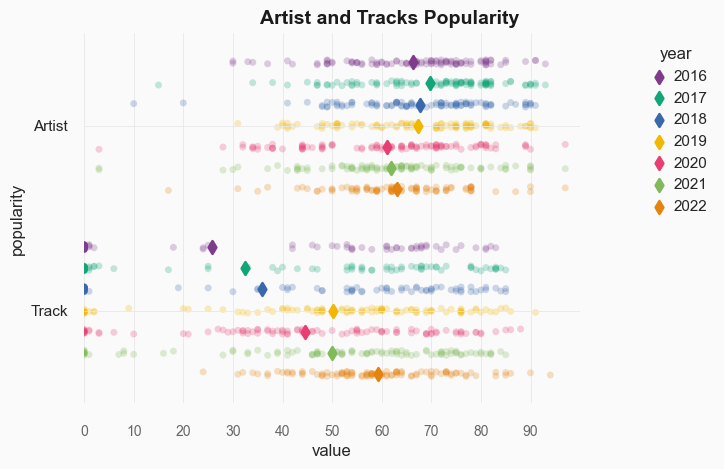

In [249]:
# Initialize layout ----------------------------------------------
sns.set_theme(style="white", rc={"axes.facecolor":(0, 0, 0, 0) , 'axes.linewidth':2, 'figure.facecolor':'"#fafafa"'})
palette = sns.color_palette("flare", 7)


# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

f.text(
    0.4,
    0.9,
    "Artist and Tracks Popularity",
    color=GREY10,
    fontsize=14,
    weight="bold"
)

# Vertical lines every year
VLINES = np.arange(0, 100,10)
# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 100), xmin=0, xmax=100, color=GREY91, lw=0.6)

# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(0, 100)

ax.set_xticks([x for x in np.arange(0, 100,10)])
ax.set_xticklabels(
    [x for x in np.arange(0, 100,10)],
    fontsize=10,
    weight=500,
    color=GREY40
)


# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")


# Show each observation with a scatterplot
sns.stripplot(
    data=popularity, x="value", y="popularity",hue="year", palette=COLOR_SCALE,
    dodge=True, alpha=.25, zorder=1, legend=False
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
point=sns.pointplot(
    data=popularity, x="value", y="popularity", hue="year",
    join=False, dodge=.8 - .8 / 7,  palette=COLOR_SCALE,
    markers="d", scale=.95, errorbar=None
)

# Improve the legend
sns.move_legend(
    ax, loc="upper left", frameon=False, columnspacing=1, handletextpad=0,bbox_to_anchor=(1.1, 1))
